# Determining the Exponent of Oscillatory Matrices

## Introduction
A matrix $A\in\R^{n\times n}$ is called **oscillatory** if it is invertible and TN (I-TN) and there exists a postive integer $q$ such that $A^q$ is TP. The least positive integer $r=r(A)$ such that $A^r$ is TP is called the *exponent* of the oscillatory matrix $A$. Determining the exponent of an oscillatory matrix is an important task.

Oscillatory matrices admit Successive Elementary Bidiagonal (SEB) factorizations that are associated with planar networks. To show that $A^r$ is TP, for $A$ oscillatory, it is enough to show that all corner minors of $A^r$ are positive. Equivalently, it is enough to show that for each corner minor, at least one family of vertex-disjoint paths, connecting the minor's source and destination indexes, exists in the planar network associated with the SEB factorization of $A^r$.

Here, we implemented few tools that can be used to determine the exponent of an oscillatory matrix based on the families of vertex-disjoing paths. For more details on oscillatory matrices, SEB factorization and associated planar networks, please refer to the paper: [On the Exponent of Several Classes of Oscillatory Matrices](https://arxiv.org/abs/1910.10709).

## SEB Factorization and Planar Networks
Let $L_i(q)\in\R^{n\times n}$, $q\ge 0$, denote a matrix with $1$ along the diagonal, $q$ in entry $(i,i-1)$ and $0$ elsewhere, and let $U_i(q):=(L_i(q))^T$. $q$ is called the parameter of $L_i(q)$. Note that $L_i(0)=I$ for all $i$. Then an oscillatory matrix $A$ can be written as $A=LDU$, with (we omit the parameter values) $L=[L_n\cdots L_2]\cdots [L_n]$, $U=[U_n]\cdots [U_2\cdots U_n]$, and $D$ diagonal with positive diagonal entries. This is called the *SEB factorization* of the oscillatory matrix $A$.
For example, for $n=5$, an oscillatory matrix $A\in\R^{5\times 5}$ can be written as $A=LDU$ with
$$
\begin{equation}
L:=[L_5L_4L_3L_2][L_5L_4L_3][L_5L_4][L_5],
\label{eq:L}
\tag{1}
\end{equation}
$$
and
$$
\begin{equation}
U:=[U_5][U_4U_5][U_3U_4U_5][U_2U_3U_4U_5].
\label{eq:U}
\tag{2}
\end{equation}
$$

Associated with the SEB factorization is a *planar network*. Each $L_i(q)$ [$U_i(q)$] is described by a diagram consisting of a diagonal directed edge (with weight $q$) from index $i$ to index $i-1$ [from index $i-1$ to index $i$], and $n$ horizontal directed edges (with weight of $1$). The diagram corresponding to the matrix $D$ consists of $n$ horizontal directed edges with weights $d_{ii}$. The planar network associated with an SEB factorization is established by concatenating, in order, the diagrams corresponding to all $L_i$, $D$, and all the $U_i$ matrices.
The following planar network is associated with the SEB factorization given in $\eqref{eq:L}$ and $\eqref{eq:U}$:

<img src="fig_exp1.png" width="1200" />

Given an oscillatory matrix $A=LDU$, we implement the computation of the family of vertex-disjoint paths corresponding to all lower-left [upper-right] corner minors of $L$ [$U$]. The paths corresponding to $U$ are determined by computing the paths of all lower-left corner minors of $U^T$, and then converting them to the paths of all upper-right corner minors of $U$.
Specifically, for each lower-left corner minor, we compute the minimum number of copies of $A$ such that a family of vertex-disjoint paths can be realized. In addition, we display the corresponding family for each corner minor, for both $L$ and $U$.


We use a **triangle graph** that is derived from the planar network associated with the left-hand side of the SEB factorization of I-TN matrices to deduce the families of paths.

## Triangle Graph
A triangle graph consists of $n-1$ columns of cells ordered left to right. The first (left-most) column represents the product $[L_n\cdots L_2]$, the second column represents the product $[L_{n-1}\cdots L_2]$, and so on, where the last column represents $[L_n]$. In each column, the top cell represents the existence/absence of $L_n$ (in the product $[L_n\cdots L_2]$), that is, it represents the boolean value $\ell_n>0$, where $\ell_n$ is the parameter of $L_n$. The second-top cell represents the existence/absence of $L_{n-1}$, and so on, where the bottom cell represents the existence/absence of $L_{2}$. Similarly for the other columns. Thus, the first column contains $n-1$ cells, the second $n-2$ cells and so on, where the last column contains a single cell. 

We say that a triangle graph represents the *signature* of the left-hand side SEB factorization, that is, it represents $\ell_i>0$ rather than the value $\ell_i$ for all $i$. Thus, an oscillatory matrix $A=LDU$, is associated with two triangle graphs: one corresponding to $L$ and one to $U^T$.

The graph also contains indexes on the left and in the bottom. These represent the source and destination indexes, respectively, of a lower-left corner minor.
The indexes of a lower-left corner minor are denoted by $s|d$, where $s$ [$d$] denotes the source [destination] indexes. For example, the lower-left corner minor indexes for $n=5$ (excluding the determinant) are: 
1. $5|1$. In the context of paths along the triangle graph, this corresponds to a family of one path from the source index 5 to the destination index 1.
2. $4,5|1,2$. This corresponds to a family of two vertex-disjoint paths: a path from 4 to 1, and a path from 5 to 2.
3. $3,4,5|1,2,3$. This corresponds to a family of three vertex-disjoint paths: a path from 3 to 1, from 4 to 2, and from 5 to 3.
4. $2,3,4,5|1,2,3,4$. This corresponds to a family of four vertex-disjoint paths: a path from 2 to 1, a path from 3 to 2, a path from 4 to 3, and a path from 5 to 4.

Below is an example of a triangle graph for $n=5$. Here, "O" indicates the existence 
of the corresponding $L_i$ matrix, and "X" the absence. 
The first column in the triangle graph corresponds to $L_5L_4L_3L_2$, the second to $L_5L_4L_3$, 
the third to $L_5L_4$ and the last column to $L_5$. Recall that in each column in the graph, the top sign (i.e. "O" or "X") 
corresponds to $L_n$ in $[L_nL_{n-1}....L_i]$. 

The following triangle graph corresponds to $L=[L_5L_3L_2][L_5L_3][L_4][L_5]$:

***
                       5 O
                       4 X O
                       3 O X X
                       2 O O O O
                         1 2 3 4

***

This triangular graph corresponds to the left-hand side of the following planar network:

<img src="fig_exp.png" width="1200" />


## Vertex-Disjoint Paths
A path in the triangle graph is defined by a sequence of 2D points along the graph. We 
start at a source index on the left, and move **either down or diagonally** along the graph. 
Moving diagonally in the triangle graph corresponds to a horizontal path in the planar network. 
Moving down in the graph corresponds to moving down along an edge in the planar network.

The flow along the cells in the triangle diagram is done as follows:
* At a "O" cell, we move down if we have yet to reach the destination index, otherwise we move diagonally.
* At a "X" cell, we move diagonally.

We stop once we reach the destination index.

A path in the triangle graph is represented by a list of 2D points (which are lists by themself
of two numbers: the y-axis value and the x-axis value). 
For example, the path that starts in the source index 5 (i.e. in the 2D point [5,1]) in the
graph above and ends in the destination index 3 (i.e. in the 2D point [1,3]) is:
 
 [[5,1],[4,1],[3,2],[2,3],[1,3]]. 

Note that in this case, this is the minimal destination index that the 
source index 5 ([5,1]) can reach in the graph. This path corresponds to the following steps:

1. Starting from [5,1] corresponds to starting in the cell that corresponds to the index 5 (the top cell of the first column). This cell contains an "O" sign.
2. Moving down to the "X" sign below it (i.e. to [4,1]) corresponds to using the diagonal edge in $L_5$ in the product $[L_5L_3L_2]$  (in the planar network).
3. Moving diagonally to the "X" sign in the second column (i.e. to [3,2]) corresponds to using an horizontal edge (in the planar network).
4. Moving diagonally to the "X" sign in the third column (i.e. to [2,3]) corresponds to using an horizontal edge (in the planar network).
5. Moving down to [1,3] corresponds to using the diagonal edge in $L_4$ in $[L_4]$. At that point we reached the destination index. 

Given a 2D point in the triangle graph $[q_y, q_x]$ the corresponding index in the planar network 
is $q_y+q_x-1$. Thus, the path above corresponds to the following path in the planar network:

  [5, 4, 4, 4, 3].

In cases where a destination can not be reached (for example, 
in the example above, the source [5,1] (i.e. index 5) can not reach the destination [1,1] (i.e. index 1)) an additional
"copy" of the triangle graph is used. This is repeated until a path is realized.

Consider the left corner minor indexes $5|1$ and the triangle diagram above. Since a path starting from the source index 5 can only terminate in the minimal destination index 3, which is larger than the required destination index 1, we say that in a single copy of the graph, index 5 can reach index 3. We then use another copy of the triangle graph, however this time we start from the source index 3. In this copy, the path is $[[3,1],[2,1],[1,1]]$, that is in the second copy of the graph index 3 can reach index 1. Thus, we require two copies of the graph for index 5 to reach index 1, and the corresponding path is represented as a list of two lists, the first is the path in the first copy and the second is the path in the second copy:

$$[ [[5,1],[4,1],[3,2],[2,3],[1,3]],  [[3,1],[2,1],[1,1]] ].$$

For a general lower-left corner minor indexes $n-x+1,\cdots, n|1,\dots,n$, ($x\in\{1,\dots,n-1\}$), we start by trying to realize a path from the smallest index, i.e. a path from $n-x+1$ to $1$. We then move to realizing a path from $n-x+2$ to $2$, etc. For a given source index, once a path is generated in a single copy of the triangle diagram (which doesn't necessarily terminates in the required destination index), the cells above the path's cells are marked by "X". This is done to insure that all paths are vertex-disjoint paths. However, when using a new copy of the triangle diagram, we revert back to the original diagram without the added "X" marks.


In the context an oscillatory matrix $A=LDU$, we use the triangle graph to compute the families of
vertex-disjoint paths corresponding to all lower-left corner minors of $L$ and $U^T$, and thus deduce
the exponent of $A$.


## Functions and Classes

In [1]:
from collections import defaultdict
import numpy as np
import pprint
import copy 
import re
import networkx as nx
import TP_TN_OSC_funcs as tpf  # generated by eb_factorization_example.ipynb

'''
Functions for lower-left corner minor paths.
=============================================
'''

def draw_triag_graph(tbl: list, ax, noffset: list=[0.1, 0.1], font_size: int=24, font_color: str='r', \
            node_size: int=200) -> None:
    '''
    This function draws the triangle graph in the matplotlib Axis object ax.
    
    For the input tbl, see the tf_tbl attribute of Trig_G() class.
    
    '''
    n = tbl.shape[0]+1
    G = nx.DiGraph()  # directed graph
    
    # add the network nodes
    cnt = 0
    for i in range(n):
        for j in range(n-i):
            G.add_node(cnt, pos=(i,j))
            cnt += 1
            
    # add all diagonal edges
    cnt, delta = 1, n-1
    for i in range(n-1):
        for _ in range(1,n-i):
            G.add_edge(cnt, cnt+delta, weight=1)
            cnt += 1
        cnt, delta = cnt+1, delta-1
    
    # down edges are added based on tbl input
    cnt = 1
    for i in range(n-1):
        for j in range(1,n-i):
            if tbl[j-1,i]:
                G.add_edge(cnt, cnt-1, weight=1)
            cnt += 1
        cnt += 1

    # node names
    # left side names
    lnames = {k:v for (k,v) in zip(np.array(range(1,n)), np.array(range(2,n+1)))}
    # bottom names
    cs = np.append([0],np.cumsum(np.array(range(n, 1, -1))))
    bnames = {k:v for (k,v) in zip(cs, np.array(range(1,n+1)))}
    nnames = {**lnames, **bnames} # node names    
    
    # offset node labels
    pos = nx.get_node_attributes(G,'pos')
    pos_n = pos.copy()
    # left names offset
    for k in range(1, n):
        pos_n[k] = (pos_n[k][0]-noffset[0], pos_n[k][1])
    # bottom names offset
    for k in cs:
        pos_n[k] = (pos_n[k][0], pos_n[k][1]-3*noffset[1])
    
    nx.draw(G, pos, ax=ax, node_size=node_size)
    nx.draw_networkx_labels(G, pos_n, ax=ax, labels=nnames, font_size=font_size, font_color=font_color);


def valsL2L_info(valsL: list) -> list:
    '''This function generates L_info given the
    L_i parameter values corresponding to [L_n*...*L_2]*[L_n*...*L_3]*...*[Ln].
    
    L_info is a list of lists. Each list element in L_info contains all the i indexes
    for which L_i exists in the EB factorization. The first list element in info
    corresponds to [L_n,...,L_2], the second to [L_n,...,L_3], etc.
    
    For example, for n=4 and left-hand side factorization [L5_L_4L_2][L_5L_3][L_5L_4][],
    the corresponding L_info is [[5,4,2],[4,3],[5,4],[]].
    
    See the function EB_factorization_ITN() in TP_TN_OSC_funcs.py that 
    generates valsL given an I-TN matrix A = LDU.
    Note that valsL here can also be equal to valsU that is also generated by 
    EB_factorization_ITN() in order to generate the L_info of U^T.
    '''
    n = tpf.EB_factorization_k2n(len(valsL))
    all_L = list(tpf.compute_L_indexes(n))
    cms = np.r_[[0], np.cumsum([x for x in range(n-1,0,-1)])]  # [0 cumsum([n-1,...,1])]
    L_info = []
    for i in range(n-1):
        g = all_L[cms[i]:cms[i+1]]      # the corresponding section in the factorization
        v = valsL[cms[i]:cms[i+1]] > 0  # the corresponding L_i with parameter>0
        L_info.append([k for (k, f) in zip(g, v) if f])
    return L_info

def is_L_info_valid_ITN(info: list) -> bool:
    '''This function checks if info corresponds
    to a left-hand size of the SEB factorization of an I-TN matrix. 
    It simply checks that info contains at least one instant of the values
    2,...,n.'''
    flat = set([i for j in info for i in j])
    return all([k in flat for k in range(2,len(info)+2)])

def init_tri_tbl(L_info: list):
    '''This function initializes a triangle table based on the left-hand side
    of the SEB factorization.
    
    The returned numpy array contains the True/False triangle table located 
    upside-down in its upper-left side. All the other elements in the returned
    table (i.e. elements outside the upside-down triangle) are set to False.
    
    For example, for L_info = [[5,4,2],[4,3],[5,4],[]], the returned array is:
    
    [[ True  True  True False]
     [False  True  True False]
     [ True False False False]
     [ True False False False]]
     
     i.e. the upside-down True/False triangle table is:
     
      True  True  True  False
     False  True  True
      True False 
      True
      
      which correspondonds to the (not upside-down) triangle table:
      
      O
      O X
      X O O 
      O O O X
    '''
    n1 = len(L_info)
    tbl = np.zeros((n1,n1), dtype=bool)

    for x in range(n1):
        for y in range(n1+1,x+1,-1):
            '''we check if n,n-1,...,x+2 exists in L_info[x],
            where x = 0,1,...,n1-1'''
            tbl[y-2-x,x] = y in L_info[x] 
    return tbl

def view_tri_tbl(tri_tbl: list, pre: str ='', lb: dict={True: 'O', False: 'X'}, verbose: bool=True, dig_width: int=2, num_space: int=1) -> None:
    '''This function displays the triangle graph tri_tbl.'''
    s = ' '
    for show, y in enumerate(range(tri_tbl.shape[0]-1, -1, -1), start=1):
        print(pre, end='')
        if verbose:
            print(f"{y+2:{dig_width}}{s*num_space}", end='')
        for x in range(show):
            print(f"{lb[tri_tbl[y,x]]}", end=s*num_space)
        print()
        
    if verbose:
        print(f"{pre}{s*(num_space+dig_width)}", end='')
        for i in range(tri_tbl.shape[0]):
            print(f"{i+1}", end=s*num_space)
        print()

        
def gen_LL_minor_indexes(n: int, x: int):
    '''This function generates a lower-left minor indexes. 
    The indexes in the minor are n-x+1,...,n|1,...,x. 
    This is returned as a numpy array np.array([[n-x+1,...,n], [1,...,x]])
    '''
    return np.array([[i for i in range(n-x+1,n+1)],[i for i in range(1,x+1)]])

def minor_indexes2str(mnr) -> str:
    '''This function converts the numpy 2D array of the minor indexes to a string
    "s|d", where s contains the source indexes and d the destination indexes.
    For example minor_indexes2str([[5,6],[1,2]]) results in '5,6|1,2'.
    '''
    return f"{','.join(map(str, mnr[0,:]))}|{','.join(map(str, mnr[1,:]))}"

def index_path(tf_tbl, d: int, oy: int=1, ox: int=0) -> list:
    '''This function computes the path of a source index to its destination
    index in the triangle graph. d here is the destination (1D) index.
    The start 2D index in the graph is (y,x)=(tf_tbl.shape[0],1) and we move 
    along the triangle graph either down (if we can, i.e.
    if there is no X) or diagonally (in which case we increase 
    the x axis index). We stop once we reach a destination (i.e. 
    if (y+1)+x=1+d).
    '''
    x, p = 1, []
    for y in range(tf_tbl.shape[0],0,-1):
        p.append([y,x])
        '''We move diagonally (corresponkding to horizontal
        path in the planar network) if:
        1. We encountered X (i.e. False), or
        2. We reached the destination 2D index. A destination 2D index
           is [1,d], and we reached a destination index if (y+1)+x = 1+d.
           Recall that here y values are: n-1,n-2,...,1, thus we need to add
           1 to y to get the real 2D index.'''
        if (not tf_tbl[y-1,x-1]) or (x+y==d):
            x += 1  
            
    # convert to indexes corresponding to the triangle graph.
    return path_offset(p+[[y-1,x]], oy, ox)      


def update_tf_tbl(po: list, tri_tbl) -> None:
    '''This function adds X (i.e. False) in the 2D indexes that are above the given path po. 
    An index above (y,x) is defined by (y+1,x). 
    Note that in po, y take values from 2,3,...,n, and x take values from 1,2,...,n-1.
    Thus, in the numpy triangle table tri_tbl (where y values are 0,1,...,) we need to 
    decrease y by 1 in order to mark the 2D index above the corresponding y indexes in po.
    '''
    for y,x in po:
        tri_tbl[y-1,x-1] = False  # the 2D index above the indexes in the path po
        #tri_tbl[y-2,x-1] = False # the indexes in the path po

def tf_tbl_trig_slice(tf_tbl, y: int):
    '''Given a value y (y \in\{2,3,...,n\}), the function returns the triangle sub-table
    whos top-left 2D index is (y,1).'''
    return tf_tbl[0:y-1,0:y-1]

def path_offset(p: list, oy: int, ox: int=0) -> list:
    '''This function offsets the y and x indexes in the path p.'''
    po = copy.deepcopy(p)
    for i in range(len(p)):
        po[i][0] += oy
        po[i][1] += ox

    return po

def path_2to1(path:list) ->list:
    '''This function converts a 2D representation of a path to 1D representation.
    For example path_2to1([[5,1],[4,2],[3,2],[2,2],[1,3]]) returns [5,5,4,3,3]'''
    return [x+y-1 for (x,y) in path]

def show_1dpath(path1d: list, flip=None, compress=None) -> str:
    '''This function returns a string in the form x1->x1->...x_n, 
    for path1d = [x1,x2,...,xn]. If flip is not None then
    the returned string is xn->...->x1.
    If compress is not None, the returned string is x1-->xn (or xn-->x1)'''
    compress = False if compress is None else True
    p = path1d.copy()[::-1] if flip else path1d
    s = ''
    if compress:
        s = f"{p[0]}-->"
    else:
        if len(p)==1:
            s = f"{p[0]}->" 
        for x in p[:-1]:
            s += f"{x}->"

    return s+f"{p[-1]}"

def horizontal_path(idx: int) -> list:
    '''This function returns a horizontal path in the triangle graph.
       For example, if idx=3, then the horizontal path is [[3,1], [2,2], [1,3]].
       '''
    return [[idx-i,i+1] for i in range(idx)]
    
def flip_str_by_sp(llm: str, sp: str) -> str:
    '''Given a string input the function flips the string around a separator (sp).
    For example flip_str_by_sp("3,4,5|1,2,3", "|") yields "1,2,3|3,4,5".
    '''
    z = re.match(f"(.+)\{sp}(.+)", llm)
    return f"{z.group(2)}{sp}{z.group(1)}"
    
def run_ll_minor(mnr, mnr_tbl, verbose: bool=False, MAX_copies: int=100) -> tuple:
    '''This function computes the paths of a lower-left minor given a triangle graph.
    Inputs: 
       mnr: a lower-left minor indexes, i.e. n-x+1,...,n|1,...,x, in the
            form of a numpy array [[n-x+1,...,n],[1,...,x]]
       mnr_tbl: the triangle table corresponding to the minor indexes.
       
    Outputs:
       num_copies - minimum number of matrix copies in order to obtain a single family of
                    vertex-disjoint paths.
       paths - a dictionary of paths, where keys are source->destination indexes.
    '''
    tf_tbl = np.copy(mnr_tbl)
    mnr_str = minor_indexes2str(mnr)
    done, num_copies = False, 1
    cur_mnr = mnr.copy()
    num_idxs = mnr.shape[1]  # number of indexes in the minor
    dest = np.zeros(num_idxs, dtype=int)  # container for destination of each index
    idxs_done = [False for i in range(num_idxs)]
    paths = defaultdict(list)
    vprint = print if verbose else lambda *a, **k: None
    
    vprint(f"\nMinor {mnr_str}:\n-----------------------")
    while not done:
        vprint(f'\n\tCopy {num_copies}, current graph:')
        view_tri_tbl(mnr_tbl, '\t') if verbose else None
        for k in range(num_idxs):
            cur_idxs = cur_mnr[:,k]
            vprint(f"\n\tPath for {cur_idxs[0]}->{cur_idxs[1]}...")
            if cur_idxs[0] > cur_idxs[1]: 
                # have yet to reach the destination vertex, i.e. source > destination
                sl_tbl = tf_tbl_trig_slice(mnr_tbl, cur_idxs[0])
                vprint(f"\tCorresponding graph:")
                view_tri_tbl(sl_tbl, '\t') if verbose else None
                po = index_path(sl_tbl, cur_idxs[1])
                if k < num_idxs - 1: # no need to update the table after the last index
                    update_tf_tbl(po, mnr_tbl)
            else:
                '''use horizontal path as we are already in the destination. For
                example, if cur_indxs[0]=cur_indxs[1]=3, then the horizontal path
                is [[3,1], [2,2], [1,3]] '''
                po = horizontal_path(cur_idxs[1])
            vprint(f"\t{po=}")
            if (d:=po[-1][1]) == cur_idxs[1]:
                vprint(f"\tDone.")
                idxs_done[k] = True
            else:
                vprint(f"\tFinished at {d}, need at least one more copy...")

            dest[k]=d
            paths[f"{mnr[0][k]}->{mnr[1][k]}"].append(po)
        
        if not all(idxs_done):
            # prepare for another copy of the triangle table
            mnr_tbl = tf_tbl_trig_slice(np.copy(tf_tbl), dest[-1])
            num_copies += 1
            cur_mnr[0,:] = np.array(dest) # the sources of the paths for the next copy are [dest[0],...,dest[-1]]
        else:
            done = True
        if num_copies >= MAX_copies:
            print(f"Reached {MAX_copies} copies, aborting...")
            done = True

    return paths, num_copies  # note that num_copies = len(paths[k]), for any key k.


'''
Classes
=====================================
'''
class Trig_G():
    '''
    Triangle graph class.
    '''
    def __init__(self, info: list=None) -> None:
        self.info = info
        self.tf_tbl = init_tri_tbl(self.info)
        self.n = len(self.info)+1
        self.valid_ITN = is_L_info_valid_ITN(self.info)
        
    def show_trig_tbl(self, pre: str='') -> None:
        view_tri_tbl(self.tf_tbl, pre) if self.info else None
        
    def __repr__(self):
        return f"Trig_G({self.info})"
    
    def __str__(self):
        return f"Triangle graph representing {self.info} and stored as:\n{self.tf_tbl}\n"
    
    def __len__(self):
        return self.n
    
    def __add__(self, other):
        '''Adding two Trig_G objects implies concatenating uniquely indexes in info.'''
        if self.n == other.n:
            return Trig_G([list(set(self.info[i]+other.info[i])) for i in range(self.n-1)])
        print(f"Adding two Trig_G objects with different sizes is not allowed!!")
            

class LLC_families():
    '''Families of vertex-disjoint paths class based along a triangle graph using the Trig_G class'''
    def __init__(self, t_graph, name: str) -> None:
        self.t_graph = t_graph
        self.indexes = [i+1 for i in range(self.t_graph.n-1)]
        self.name = name
        self.vd_families = None
        self.rvd_families = None
        self.num_copies = None
        self.r = 0
        
    def __repr__(self):
        return f"LLC_families({self.t_graph}, {self.name})"
        
    def display_raw_results(self) -> None:
        print(f"\nResults:\n-----------------")
        print("Number of copies:")
        pprint.pprint(dict(self.num_copies))
        print("Paths:")
        pprint.pprint(dict(self.vd_families))
        print("Reversed paths:")
        pprint.pprint(dict(self.rvd_families))
        print(f"Minimum number of copies to realize all families = {self.r}")

    def display_results(self, reverse=None, compress=None) -> None:
        '''Displays the results.'''
        rsl = self.vd_families if reverse is None else self.rvd_families
        #print(f"\nResults:\n-----------------")
        print(f"{self.name}:")
        for mr, m in zip(rsl.keys(),self.num_copies.keys()):
            print(f"\t{mr}", end=' ')
            print(f"({self.num_copies[m]} copies):") # number of copies
            for p in rsl[mr].keys():
                s = ''.join([f"[{show_1dpath(path_2to1(q), compress=compress)}]" for q in rsl[mr][p]])
                print(f"\t\t{s}")
        print(f"Minimum number of copies to realize all families = {self.r}.")

    def reverse_paths(self) -> None:
        '''This function reverse the paths to be from destination sets to source sets.'''
        rsl = self.vd_families
        Ursl = defaultdict(dict)
        for k in rsl.keys():  # keys here are the minors
            '''
            we reverse the order here since in a upper-right corner minor
            we start the paths with the maximal index (as oppose to the case of
            a lower-left corner minor where we start with the minimal index).
            '''
            Ursl[flip_str_by_sp(k, sp='|')] = \
            {flip_str_by_sp(pi, sp='->'): [p[::-1] for p in rsl[k][pi][::-1]] for pi in sorted(rsl[k].keys(), reverse=True)}
        self.rvd_families = dict(Ursl)


    def run(self, verbose: bool=True) -> None:
        '''This function computes the paths and number of copies.'''
        if verbose:
            print(f'Triangle table:') 
            view_tri_tbl(self.t_graph.tf_tbl)
                
        # containers per minor
        mnrs_num_copies = defaultdict(int)
        mnrs_paths = defaultdict(dict)
        #ll_mnr_indx = [i+1 for i in range(self.t_graph.n-1)]
        # Path analysis for a minor 
        for l in [i+1 for i in range(self.t_graph.n-1)]:
            mnr_tbl = np.copy(self.t_graph.tf_tbl)
            mnr = gen_LL_minor_indexes(self.t_graph.n, l)
            mnr_str = minor_indexes2str(mnr)
            
            # computes paths per minor
            paths, ncopies = run_ll_minor(mnr, mnr_tbl)
                
            if verbose:
                print(f"\n{mnr_str}: {ncopies} copies. Paths:")
                for k in paths.keys():
                    print(f"{k}:")
                    for i in range(len(paths[k])):
                        print(f"\tCopy {i+1}: {paths[k][i]}")  
            mnrs_num_copies[mnr_str] = ncopies
            mnrs_paths[mnr_str] = dict(paths)
                
        self.vd_families = dict(mnrs_paths)
        self.num_copies = dict(mnrs_num_copies)
        self.reverse_paths()  # this populates self.rvd_families
        self.r = max(self.num_copies.values())
                        
    def get_results(self):
        return self.num_copies, self.vd_families, self.rvd_families

class OSC_exp():
    '''Oscillatory matrix class that generates the paths and number of copys for L and U^T (given
    an oscillatory matrix A=LDU), and thus the exponent value.'''
    names: dict = {'L': 'L', 'UT': 'U^T'}

    def __init__(self, A, names=None) -> None:
        if names is not None:
            if len(names) != len(self.names):
                raise ValueError(f"OSC_exp Error: names input must be a list containing {len(self.names)} strings!!")
            self.names = {k:v for k,v in zip(self.names.keys(), names)}
        self.A = A
        self.G: dict = {}  # Trig_G objects for L and for U^T
        self.LC: dict = {} # LLC_families objects for L and U^T
        self.LU_info: dict = {}  # L_i and (U^T)_i with positive parameter values

    def __repr__(self):
        return f"OSC_exp({self.A})"
    
    def __str__(self):
        return f"Paths and exponent of the matrix A=\n{self.A}\n"
    
    def __len__(self):
        return self.A.shape[0]
            
    @classmethod
    def from_vals_ldu(cls, valsl, valsd, valsu):
        '''creating the oscillatory matrix from the SEB factorization parameters'''
        return cls(tpf.compute_matrix_from_EB_factorization(valsl, valsd, valsu))

    def run(self, verbose: bool=False) -> None:
        _, _, _, _, valsL, valsU  = tpf.EB_factorization_ITN( self.A )  
        self.LU_info[self.names['L']] = valsL2L_info(valsL)
        self.LU_info[self.names['UT']] = valsL2L_info(valsU)
        self.G = {self.names['L']: [], self.names['UT']: []}
        self.LC = {self.names['L']: [], self.names['UT']: []}
        
        for k in self.names.values():
            self.G[k] = Trig_G(info=self.LU_info[k])
            self.LC[k] = LLC_families(self.G[k], k)
            self.LC[k].run(verbose=verbose)
        self.r = max([self.LC[k].r for k in self.names.values()])
        
    def display_results(self, show_also_reverse=None, compress=None) -> None:
        show_reverse = False if show_also_reverse is None else True
        for k in self.names.values():
            print(f"\n{k}:")
            self.G[k].show_trig_tbl()
            self.LC[k].display_results(compress=compress)
            if show_reverse:
                # display reverse paths and number of copies results for L
                print('\nDestination->Source results:')
                self.LC[k].display_results(compress=compress, reverse=True)
        print(f"\nr(A) = {self.r}.")
             

## An example from the description section above
This is the example used above in the description section for $n=5$. 

Triangle graph corresponding to mat_info:
 5 O 
 4 X O 
 3 O X X 
 2 O O O O 
   1 2 3 4 
A draw of triangle graph:


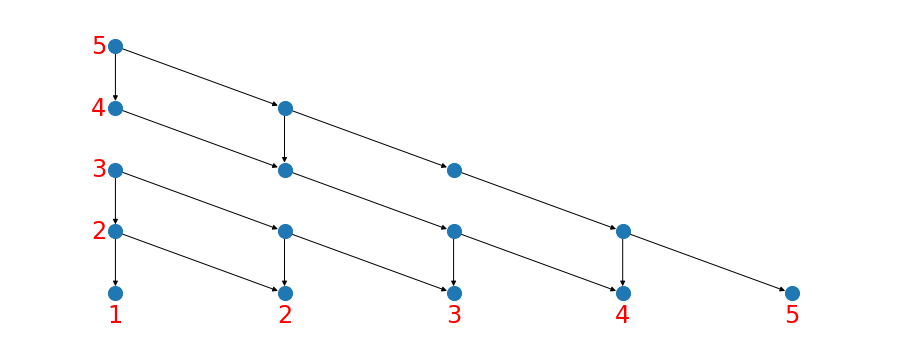


Graph correponds to rhs of I-TN matrix: True

Source->Destination results (verbose):
L:
	5|1 (2 copies):
		[5->4->4->4->3][3->2->1]
	4,5|1,2 (3 copies):
		[4->4->4->3][3->2->1][1->1]
		[5->5->5->5->4][4->4->4->3][3->2->2]
	3,4,5|1,2,3 (2 copies):
		[3->2->1][1->1]
		[4->4->4->3][3->2->2]
		[5->5->5->5->4][4->4->4->3]
	2,3,4,5|1,2,3,4 (1 copies):
		[2->1]
		[3->3->2]
		[4->4->4->3]
		[5->5->5->5->4]
Minimum number of copies to realize all families = 3.

Source->Destination results (compressed):
L:
	5|1 (2 copies):
		[5-->3][3-->1]
	4,5|1,2 (3 copies):
		[4-->3][3-->1][1-->1]
		[5-->4][4-->3][3-->2]
	3,4,5|1,2,3 (2 copies):
		[3-->1][1-->1]
		[4-->3][3-->2]
		[5-->4][4-->3]
	2,3,4,5|1,2,3,4 (1 copies):
		[2-->1]
		[3-->2]
		[4-->3]
		[5-->4]
Minimum number of copies to realize all families = 3.


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import display
''' Define the input which is a list of L_i with positive parameters.
Here, L_4 is missing from [L_5L_4L_3L_2], L_4 is missing from
[L_5L_4L_3], L_5 is missing from [L_5L_4] and L_5 is not missing from [L_5]
'''
mat_info = [[5,3,2], [5,3], [4], [5]]  
# -----------------------------------------------------------------------------
# create a triangle graph object
G_L = Trig_G(info=mat_info)
# display the triangle graph
print("Triangle graph corresponding to mat_info:")
G_L.show_trig_tbl()
# can also draw the graph
print("A draw of triangle graph:")
plt1, ax = plt.subplots(figsize=(16,6))
draw_triag_graph(G_L.tf_tbl, ax, noffset=[0.1, 0.12])
ax.margins(.1, .1)    
display(plt1)
plt.close()
# check if it corresponds to a rhs of the SEB of an I-TN matrix
print(f"\nGraph correponds to rhs of I-TN matrix: {G_L.valid_ITN}")
# create a lower-left corner minor object based on the triangle graph object
LC = LLC_families(G_L, name='L')
# run the paths computation
LC.run(verbose=False)
# display paths and number of copies results
print('\nSource->Destination results (verbose):')
LC.display_results()
print('\nSource->Destination results (compressed):')
LC.display_results(compress=True)

## Another example of using Trig_G and LLC_families classes
Here, the input is a list of available $L_i$ matrices in each group in the left-hand side of the SEB factorization.

In [3]:
''' Define the input which is a list of L_i with positive parameters.
Here, L_4 and L_3 are missing from [L_5L_4L_3L_2], L5 and L_4 are missing from
[L_5L_4L_3], L_5 is missing from [L_5L_4] and L_5 is not missing from [L_5]
'''
mat_info = [[5,2], [3], [4], [5]]  
# -----------------------------------------------------------------------------

# create a triangle graph object
G_L = Trig_G(info=mat_info)
# display the triangle graph
print("Triangle graph corresponding to mat_info:")
G_L.show_trig_tbl()
# check if it corresponds to a rhs of the SEB of an I-TN matrix
print(f"\nGraph correponds to rhs of I-TN matrix: {G_L.valid_ITN}")
# create a lower-left corner minor object based on the triangle graph object
LC = LLC_families(G_L, name='Q')
#print(LC)
# run the paths computation
LC.run(verbose=False)
# display paths and number of copies results
print('\nSource->Destination results:')
LC.display_results()
# can also display the reverse paths and number of copies results
print('\nDestination->Source results:')
LC.display_results(reverse=True)
# can also display raw results
#LC.display_raw_results()
print(f"\nMinimum number of copies to realize all lower-left corner minors = {LC.r}.")



Triangle graph corresponding to mat_info:
 5 O 
 4 X X 
 3 X X X 
 2 O O O O 
   1 2 3 4 

Graph correponds to rhs of I-TN matrix: True

Source->Destination results:
Q:
	5|1 (3 copies):
		[5->4->4->4->3][3->3->2][2->1]
	4,5|1,2 (3 copies):
		[4->4->4->3][3->3->2][2->1]
		[5->5->5->5->4][4->4->4->3][3->3->2]
	3,4,5|1,2,3 (2 copies):
		[3->3->2][2->1]
		[4->4->4->3][3->3->2]
		[5->5->5->5->4][4->4->4->3]
	2,3,4,5|1,2,3,4 (1 copies):
		[2->1]
		[3->3->2]
		[4->4->4->3]
		[5->5->5->5->4]
Minimum number of copies to realize all families = 3.

Destination->Source results:
Q:
	1|5 (3 copies):
		[1->2][2->3->3][3->4->4->4->5]
	1,2|4,5 (3 copies):
		[2->3->3][3->4->4->4][4->5->5->5->5]
		[1->2][2->3->3][3->4->4->4]
	1,2,3|3,4,5 (2 copies):
		[3->4->4->4][4->5->5->5->5]
		[2->3->3][3->4->4->4]
		[1->2][2->3->3]
	1,2,3,4|2,3,4,5 (1 copies):
		[4->5->5->5->5]
		[3->4->4->4]
		[2->3->3]
		[1->2]
Minimum number of copies to realize all families = 3.

Minimum number of copies to realize all lower-lef

## An example of using OSC_exp class
Here, the input is an oscillatory matrix.

A =
[[3.  1.  0.  0. ]
 [1.  4.  1.  0.1]
 [0.1 1.  5.  3. ]
 [0.  0.  2.  7. ]]

Matrix A is OSC: True

L:
 4 X 
 3 O X 
 2 O O O 
   1 2 3 
L:
	4|1 (2 copies):
		[4->4->4->3][3->2->1]
	3,4|1,2 (2 copies):
		[3->2->1][1->1]
		[4->4->4->3][3->2->2]
	2,3,4|1,2,3 (1 copies):
		[2->1]
		[3->3->2]
		[4->4->4->3]
Minimum number of copies to realize all families = 2.

U^T:
 4 X 
 3 X O 
 2 O O O 
   1 2 3 
U^T:
	4|1 (2 copies):
		[4->4->3->2][2->1]
	3,4|1,2 (2 copies):
		[3->3->2][2->1]
		[4->4->4->3][3->3->2]
	2,3,4|1,2,3 (1 copies):
		[2->1]
		[3->3->2]
		[4->4->4->3]
Minimum number of copies to realize all families = 2.

r(A) = 2.

Showing paths for both lower-left and upper-right corner minors for both L and U^T:

L:
 4 X 
 3 O X 
 2 O O O 
   1 2 3 
L:
	4|1 (2 copies):
		[4->4->4->3][3->2->1]
	3,4|1,2 (2 copies):
		[3->2->1][1->1]
		[4->4->4->3][3->2->2]
	2,3,4|1,2,3 (1 copies):
		[2->1]
		[3->3->2]
		[4->4->4->3]
Minimum number of copies to realize all families = 2.

Destination->Sourc

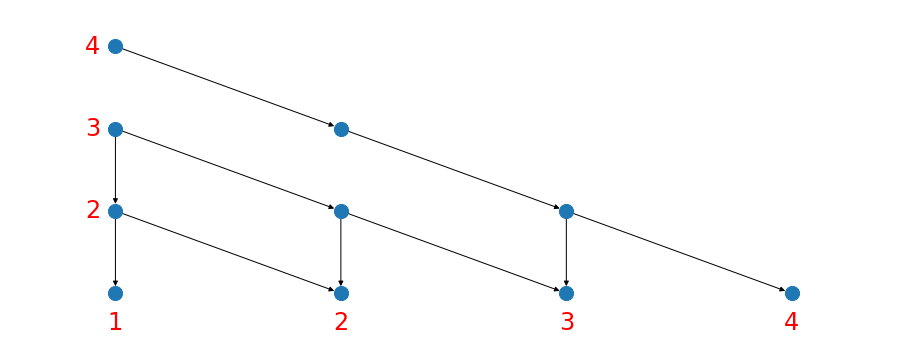

Triangle graph of U^T:


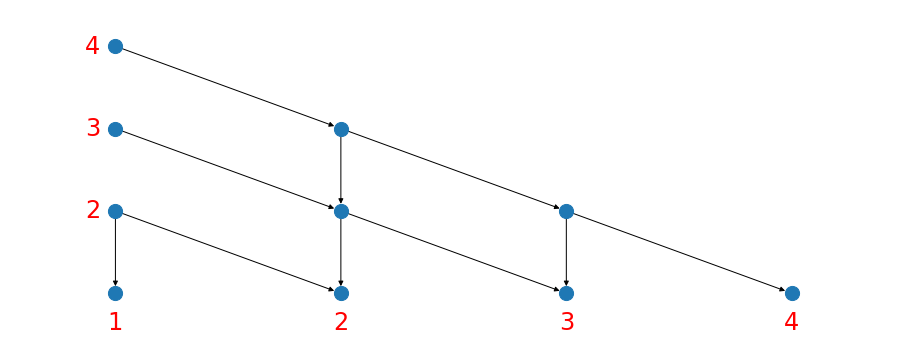

Done.


In [4]:
# define an oscillatory matrix
A = np.array([[3, 1, 0, 0], [1, 4, 1, 0.1], [0.1, 1, 5, 3], [0, 0, 2, 7]])            
# -----------------------------------------------------------------------------
print(f"A =\n{A}")
# check that this is indeed an oscillatory matrix
print(f"\nMatrix A is OSC: {tpf.is_osc_from_factorization(A)}")
try:
    osc_cls = OSC_exp(A) # create an OSC_exp object
    #print(osc_cls)
except ValueError as ve:
    print(f"{ve}. Aborting...")
else:
    osc_cls.run()  # run it
    osc_cls.display_results()  # display its results
    # or can show paths corresponding to both lower-right and upper-right corner minors
    print('\nShowing paths for both lower-left and upper-right corner minors for both L and U^T:')
    osc_cls.display_results(show_also_reverse=True) 
finally:
    for k in osc_cls.G.keys():
        print(f'Triangle graph of {k}:')
        plt1, ax = plt.subplots(figsize=(16,6))
        draw_triag_graph(osc_cls.G[k].tf_tbl, ax, noffset=[0.1, 0.12])
        ax.margins(.1, .1)    
        display(plt1)
        plt.close()
    print('Done.')


## Another example
Here, for $A=LDU$, we set $U=[U_2\cdots U_n]$ and $L = [L_n\cdots L_2][L_n\cdots L_3]\cdots[L_n]$,
that is, $L$ consists of all $L_i$ matrices in the right-hand side of the SEB factorization, and
$U$ consists of only the last group in the right-hand factorization. It is known that 
in this case, $r(A)=n-1$.

A =
[[  1.   1.   1.   1.   1.   1.   1.   1.]
 [  1.   2.   2.   2.   2.   2.   2.   2.]
 [  1.   3.   4.   4.   4.   4.   4.   4.]
 [  1.   4.   7.   8.   8.   8.   8.   8.]
 [  1.   5.  11.  15.  16.  16.  16.  16.]
 [  1.   6.  16.  26.  31.  32.  32.  32.]
 [  1.   7.  22.  42.  57.  63.  64.  64.]
 [  1.   8.  29.  64.  99. 120. 127. 128.]]

Matrix A is OSC: True

L:
 8 O 
 7 O O 
 6 O O O 
 5 O O O O 
 4 O O O O O 
 3 O O O O O O 
 2 O O O O O O O 
   1 2 3 4 5 6 7 
L:
	8|1 (1 copies):
		[8-->1]
	7,8|1,2 (1 copies):
		[7-->1]
		[8-->2]
	6,7,8|1,2,3 (1 copies):
		[6-->1]
		[7-->2]
		[8-->3]
	5,6,7,8|1,2,3,4 (1 copies):
		[5-->1]
		[6-->2]
		[7-->3]
		[8-->4]
	4,5,6,7,8|1,2,3,4,5 (1 copies):
		[4-->1]
		[5-->2]
		[6-->3]
		[7-->4]
		[8-->5]
	3,4,5,6,7,8|1,2,3,4,5,6 (1 copies):
		[3-->1]
		[4-->2]
		[5-->3]
		[6-->4]
		[7-->5]
		[8-->6]
	2,3,4,5,6,7,8|1,2,3,4,5,6,7 (1 copies):
		[2-->1]
		[3-->2]
		[4-->3]
		[5-->4]
		[6-->5]
		[7-->6]
		[8-->7]
Minimum number of copies to realize 

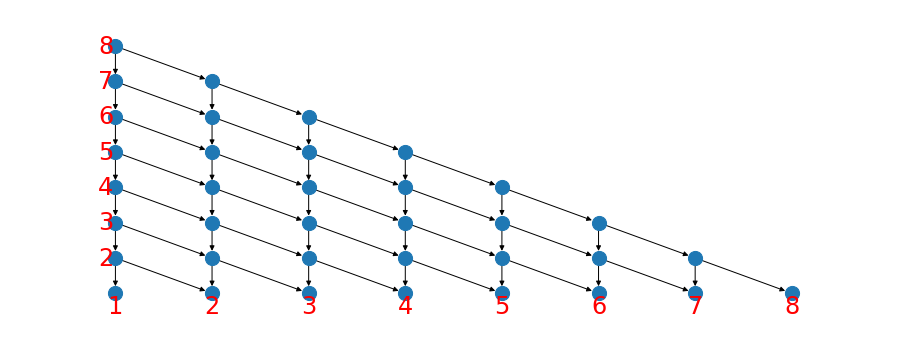

Triangle graph of U^T:


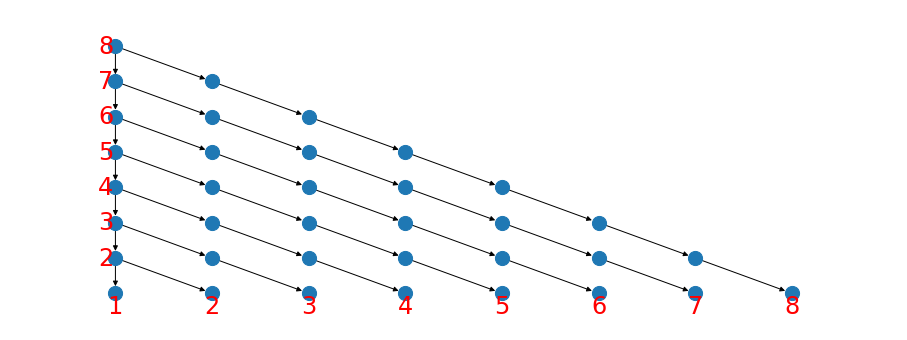

Done.


In [5]:
n = 8  # set n value
# --------------------------------------------------------------------------------------------
k = tpf.EB_factorization_n2k(n)
valsl = np.ones(k)
valsd = np.ones(n)
valsu = np.r_[np.ones(n-1), np.zeros(k-(n-1))]
A = tpf.compute_matrix_from_EB_factorization(valsl, valsd, valsu)
print(f"A =\n{A}")
# check that this is indeed an oscillatory matrix
print(f"\nMatrix A is OSC: {tpf.is_osc_from_factorization(A)}")
try:
    #osc_cls = OSC_exp(A) # create an OSC_exp object
    osc_cls = OSC_exp.from_vals_ldu(valsl, valsd, valsu) # can also create from the SEB factorization
except ValueError as ve:
    print(f"{ve}. Aborting...")
else:
    osc_cls.run()  # run it
    osc_cls.display_results(compress=True)  # display its results
finally:
    for k in osc_cls.G.keys():
        print(f'Triangle graph of {k}:')
        plt1, ax = plt.subplots(figsize=(16,6))
        draw_triag_graph(osc_cls.G[k].tf_tbl, ax, noffset=[0.2, 0.2])
        ax.margins(.1, .1)    
        display(plt1)
        plt.close()
    print('Done.')
